<a href="https://colab.research.google.com/github/ProvenDruid/FFN/blob/main/ffn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# import dataset (comes with colab!)
dataV = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = dataV[:,0]
data   = dataV[:,1:]

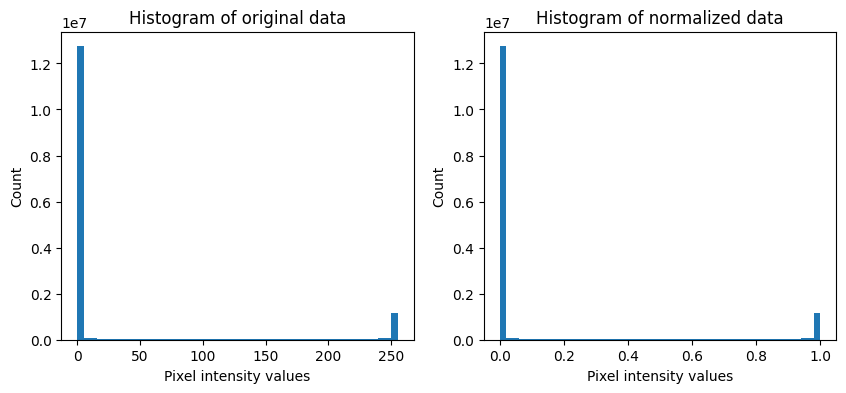

In [ ]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [ ]:
#giving format to the data
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_dataSet = TensorDataset(train_data,train_labels)
test_dataSet  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataSet,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataSet,batch_size=test_dataSet.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

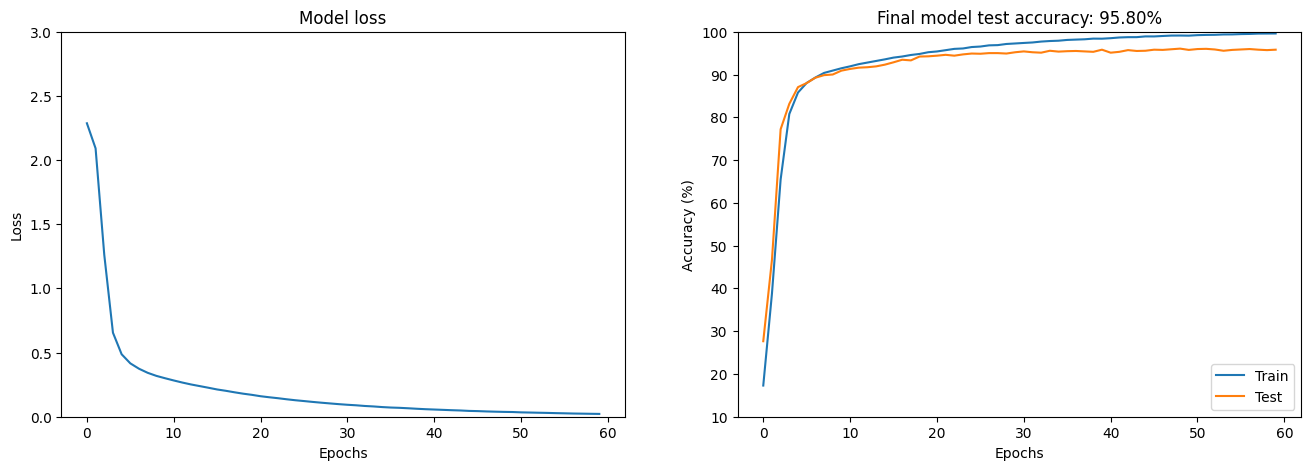

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.4064e+01, -2.1217e-04, -9.8693e+00,  ..., -1.1371e+01,
         -8.9534e+00, -1.9416e+01],
        [-1.5903e+01, -1.4517e+01, -9.5367e-07,  ..., -1.9313e+01,
         -1.4964e+01, -3.3609e+01],
        [ 0.0000e+00, -3.8457e+01, -1.7607e+01,  ..., -2.8372e+01,
         -2.2036e+01, -2.2788e+01],
        ...,
        [-1.6481e+01, -1.3058e+01, -1.6342e+01,  ..., -1.4932e+01,
         -1.2499e+01, -7.6963e+00],
        [-1.8727e+01, -8.3578e-04, -9.2430e+00,  ..., -1.0562e+01,
         -8.0626e+00, -1.6029e+01],
        [-1.5478e+01, -1.4222e+01, -1.1506e+01,  ..., -2.4385e+01,
         -7.2238e-05, -1.8703e+01]])

[  44   72  117  118  134  193  204  214  220  268  283  286  303  399
  400  432  542  549  592  618  663  688  730  776  785  793  815  851
  852  899  910  953  981 1024 1031 1039 1044 1045 1056 1066 1074 1081
 1085 1103 1123 1128 1145 1178 1219 1221 1247 1259 1262 1292 1333 1343
 1368 1385 1427 1451 1458 1477 1521 1583 1603 1605 1617 1666 1674 1733
 1771 1794 1799 1826 1873 1876 1886 1890 1910 1927 1939 1981 1988 1993]


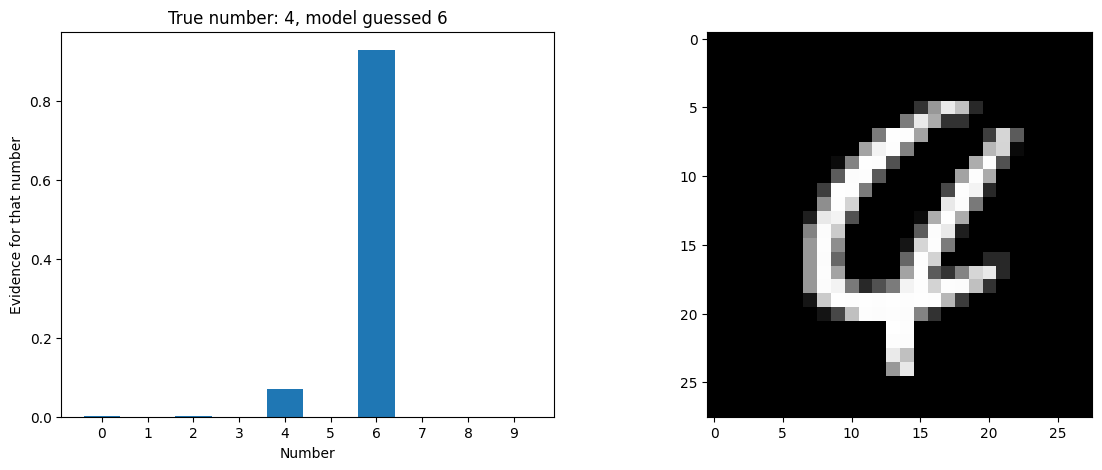

In [ ]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 5

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()